In [1]:
import fastai
from fastai import *          # Quick access to most common functionality
from fastai.vision import *   # Quick access to computer vision functionality
import PIL
import pytorch_ssim as ssim

In [2]:
path = Path('/DATA/WAMRI/SALK/uri/Image_restoration_data/')
train_lr = path/'train_LR'
train_hr = path/'train_HR'
test_lr = path/'test_LR'
test_hr = path/'test_HR'

In [3]:
def pull_id(fn):
    return fn.split('#')[-1].split('.')[0]

def match_hr_fn(x):
    return hr_names_by_id[pull_id(x.name)]

lr_names_full = list(train_lr.glob('*.tif'))
lr_names_full.sort()
hr_names_by_id = {pull_id(hrfn.name):hrfn for hrfn in train_hr.glob('*.tif')}

In [4]:
def conv(ni, nf, kernel_size=3, actn=True):
    layers = [nn.Conv2d(ni, nf, kernel_size, padding=kernel_size//2)]
    if actn: layers.append(nn.ReLU(True))
    return nn.Sequential(*layers)

class ResSequential(nn.Module):
    def __init__(self, layers, res_scale=1.0):
        super().__init__()
        self.res_scale = res_scale
        self.m = nn.Sequential(*layers)

    def forward(self, x):
        x = x + self.m(x) * self.res_scale
        return x
    
def res_block(nf):
    return ResSequential(
        [conv(nf, nf), conv(nf, nf, actn=False)],
        0.1)

def upsample(ni, nf, scale):
    layers = []
    for i in range(int(math.log(scale,2))):
        layers += [conv(ni, nf*4), nn.PixelShuffle(2)]
    return nn.Sequential(*layers)

class SrResnet(nn.Module):
    def __init__(self, n_feats, n_res, n_colors, scale ):
        super().__init__()
        features = [conv(n_colors, n_feats)]
        for i in range(n_res): features.append(res_block(n_feats))
        features += [conv(n_feats,n_feats), upsample(n_feats, n_feats, scale),
                     nn.BatchNorm2d(n_feats),
                     conv(n_feats, n_colors, actn=False)]
        self.features = nn.Sequential(*features)
        
    def forward(self, x): return self.features(x)

In [5]:
def psnr(pred, targs):
    mse = F.mse_loss(pred, targs)
    return 20 * torch.log10(1./torch.sqrt(mse))

def psnr_loss(pred, targs):
    mse = F.mse_loss(pred, targs)
    return -20 * torch.log10(1./torch.sqrt(mse))

ssim_loss = ssim.SSIM(mult=-1.)
ssim_loss_2 = ssim.SSIM(window_size=3, mult=-1.)
ssim_loss_3 = ssim.SSIM(window_size=32, mult=-1.)

def combo_loss(pred, targs):
    return (3 + 
            ssim_loss(pred, targs) + 
            ssim_loss_2(pred, targs) + 
            ssim_loss_3(pred, targs) + 
            F.mse_loss(pred, targs)
           )
    #return ssim_loss(pred, targs) + psnr_loss(pred, targs)/50. # + F.l1_loss(pred, targs)
    
metrics = [F.mse_loss, 
           ssim.ssim,
           partial(ssim.ssim, window_size=3),
           partial(ssim.ssim, window_size=32),
           psnr]

In [6]:
def open_grayscale(fn):
    x = PIL.Image.open(fn)
    return Image(pil2tensor(x,np.float32).div_(255)[0:1])   

class SuperResLabelList(ImageItemList):
    def __init__(self, items:Iterator, **kwargs):
        super().__init__(items, **kwargs)
        self.loss_func,self.create_func = combo_loss,open_grayscale
        

    def new(self, items, classes=None, **kwargs):
        return self.__class__(items, **kwargs)


class SuperResItemList(ImageItemList):
    def __post_init__(self):
        super().__post_init__()
        self._label_cls = SuperResLabelList
        self.loss_func = combo_loss
        self.create_func = open_grayscale



In [7]:
valid_pct = 0.10
src = (SuperResItemList(lr_names_full).
       random_split_by_pct(valid_pct).
       label_from_func(match_hr_fn))
      

def get_data(src, bs, sz_lr, scale=4, tfms=None, **kwargs):
    sz_hr = sz_lr*scale
    salk_stats = ( [0.10], [0.20])
    if tfms is None: tfms = get_transforms() 
    data = (src.transform(tfms, size=sz_lr)
            .transform_labels(size=sz_hr)
            .databunch(bs=bs, **kwargs) #, num_workers=0)
            .normalize(salk_stats, do_y=True))
    return data

In [8]:
n_feats = 8
n_res = 64
n_color = 1
scale=4

# 64,4,1
model = SrResnet(n_feats, n_res, n_color, scale)
model = nn.DataParallel(model).cuda()

In [10]:
bs = 16
lr_sz = 32

data = get_data(src, bs, lr_sz, scale=scale)

In [11]:
x,y = next(iter(data.train_dl))
x.shape, y.shape

(torch.Size([16, 1, 32, 32]), torch.Size([16, 1, 128, 128]))

In [12]:
learn = Learner(data, model, metrics=metrics)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


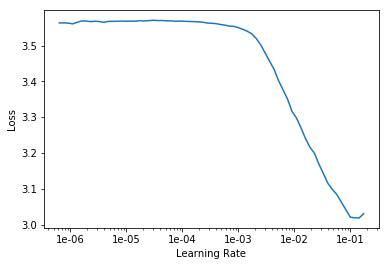

In [13]:
learn.lr_find()
learn.recorder.plot()

In [14]:
lr = 1e-2
learn.fit_one_cycle(10, lr)
learn.save('enhance-db')

Total time: 02:18
epoch  train_loss  valid_loss  mse_loss  ssim  ssim  ssim  psnr                
1      2.957578    2.274585    0.321445  0.342332  0.355993  0.348535  4.936755  (00:13)
2      2.476735    2.108187    0.217007  0.362857  0.376148  0.369816  6.674414  (00:13)
3      2.300956    2.192896    0.302970  0.361344  0.380188  0.368543  5.221049  (00:13)
4      2.228227    2.069248    0.213651  0.375852  0.385461  0.383089  6.743296  (00:13)
5      2.174341    2.062347    0.204972  0.376691  0.381913  0.384021  6.918250  (00:14)
6      2.130305    2.053043    0.209148  0.380425  0.387900  0.387780  6.834309  (00:13)
7      2.111108    2.030172    0.199602  0.385114  0.391898  0.392419  7.031152  (00:14)
8      2.080616    2.026047    0.200241  0.386877  0.393155  0.394161  7.023891  (00:13)
9      2.071270    2.027364    0.199854  0.386037  0.393117  0.393336  7.031274  (00:13)
10     2.058542    2.022764    0.197349  0.387087  0.393116  0.394382  7.086926  (00:13)



In [ ]:
x,y = data.valid_ds[0]

In [31]:
trn_tfm, val_tfm = get_transforms()
test_bs = 4
test_sz = 512 
test_out_sz = 4*512

src = (SuperResItemList(lr_names_full).
       random_split_by_pct(valid_pct).
       label_from_func(match_hr_fn))

salk_stats = ( [0.10], [0.20])

test_data = (SuperResItemList.from_folder(path/'newman', extensions='.tif')
             .split_by_idx([])
             .label_from_func(lambda x: x)
             .transform([val_tfm,val_tfm], sz=test_sz)
             .transform_labels(size=test_out_sz)
             .databunch(bs=test_bs)
             .normalize(salk_stats, do_y=False))
    
test_learn = Learner(test_data, model, path='.')
test_learn = test_learn.load('enhance-db')

In [89]:
imgs = list((path/'newman').glob('*.tif'))


def pred_and_save(img_fn):
    img = open_grayscale(img_fn)
    pred_img = test_learn.predict(img)
    img_min = pred_img.min()
    img_max = pred_img.max()
    pred_img = (pred_img - img_min) / (img_max - img_min)
    img = Image(pred_img[0])
    img.save(img_fn.name.replace('low res', 'super res'))
    return img
    
sr_images = []
for img_fn in imgs:
    new_img = pred_and_save(img_fn)
    sr_images.append(new_img)

In [90]:
sr_images

[Image (1, 2048, 2048), Image (1, 2048, 2048)]

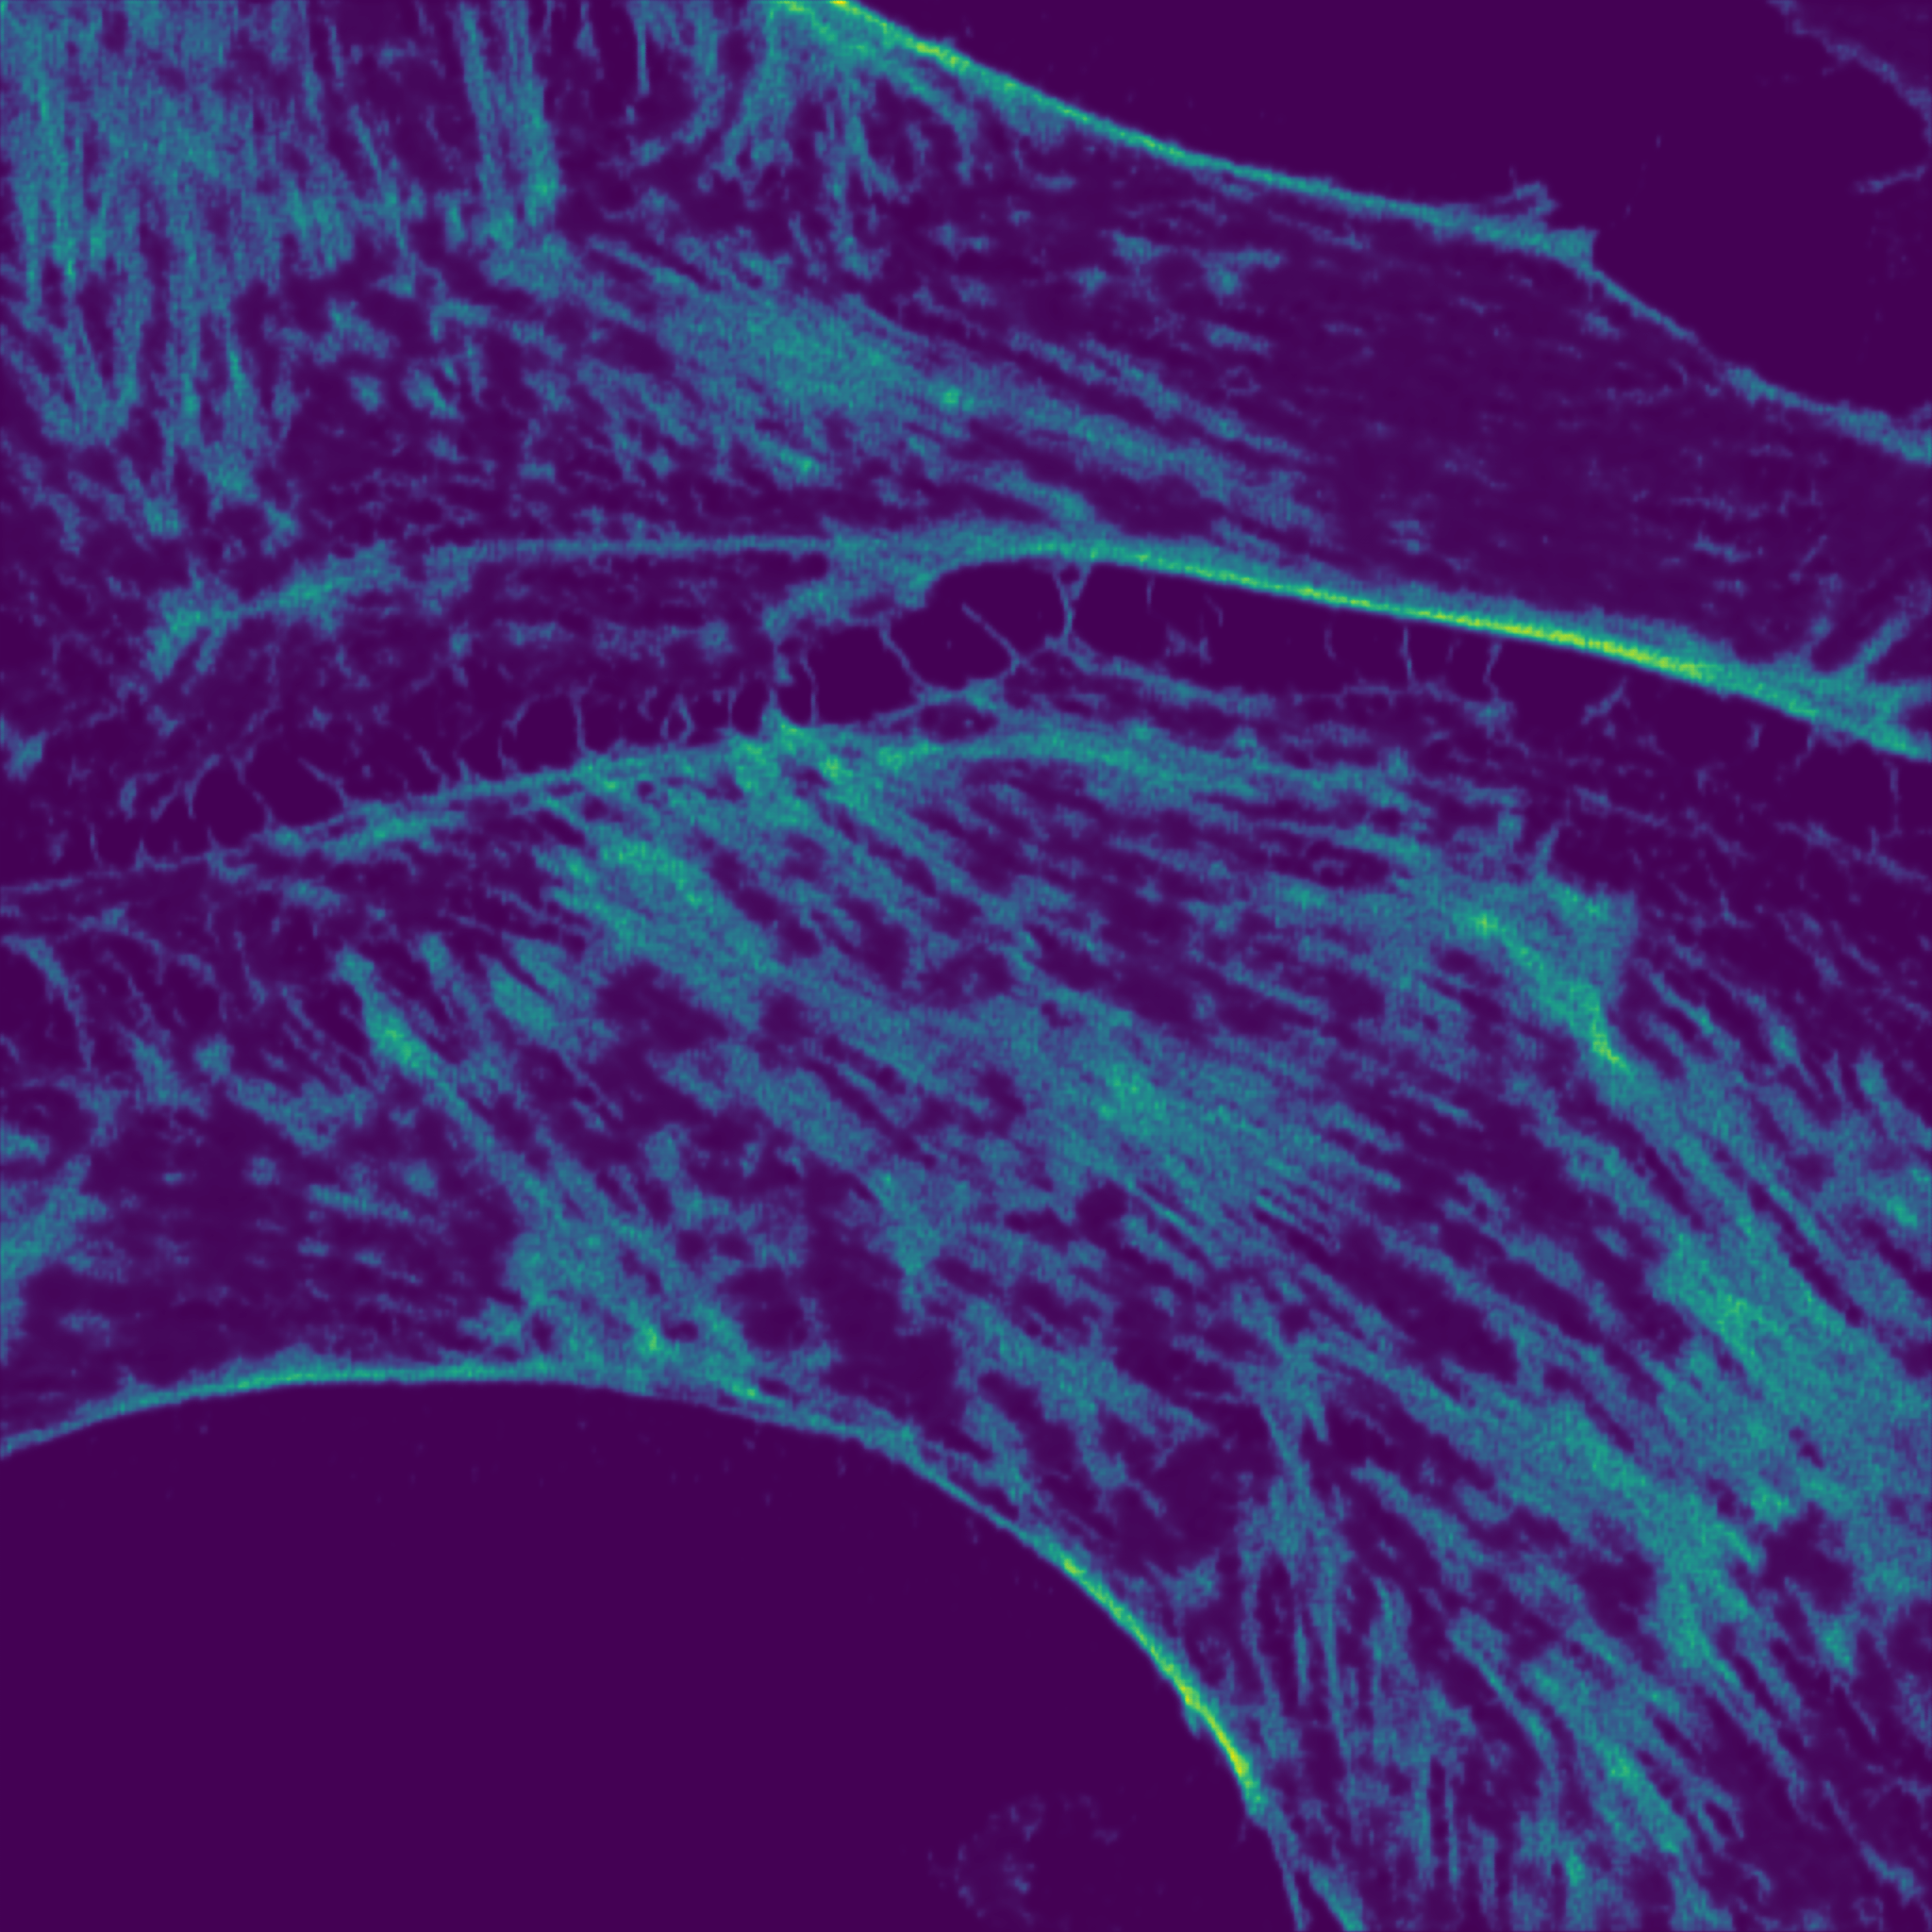

In [91]:
sr_images[0]

In [ ]:
sr_images